<a href="https://colab.research.google.com/github/LeNovice/Assignments_WILP_SEM3/blob/main/Main_CadenceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO: Refer

https://debuggercafe.com/getting-95-accuracy-on-the-caltech101-dataset-using-deep-learning/

Data Pipeline:
https://www.tensorflow.org/api_docs/python/tf/data/Dataset#as_numpy_iterator

https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map

Loading the Caltech Dataset

In [131]:
import tensorflow_datasets as tfds
import numpy as np
#For plotting the dataset
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
#Data pipeline preparation
import tensorflow as tf
from tensorflow.keras import layers
#model buildingZ
from tensorflow.keras import models

Code to get the number of samples per class

Initially we will only try to train for 10 classes.

https://github.com/tensorflow/datasets/issues/1923#issuecomment-1361608072

In [132]:
NUM_CLASSES = 10
DataSet = 'cifar10'
#'caltech101'
def num_samples_per_class(ds_train, get_top_10 = False, print_all = False):
    vals = np.unique(np.fromiter(ds_train.map(lambda x, y: y), int), return_counts=True)
    class_list = []
    class_hist = []
    for val,count in zip(*vals):
        if print_all==True:
            print(int(val), count)
        #class_hist[val] = count
        class_hist.append((val,count))
    if get_top_10 == True:
        sorted_tuple = sorted(class_hist, key=lambda t: t[-1], reverse=True)[:NUM_CLASSES]
        class_list = [x for x,y in sorted_tuple]
    return class_list

def filter_fn(x, allowed_classes:list):
    allowed_classes = tf.constant(allowed_classes)
    isallowed = tf.equal(allowed_classes, tf.cast(x, allowed_classes.dtype))
    reduced_sum = tf.reduce_sum(tf.cast(isallowed, tf.float32))
    return tf.greater(reduced_sum, tf.constant(0.))

In [133]:
#(ds, ds_info) = tfds.load(DataSet, with_info=True, as_supervised=True)

In [134]:
#ds_train, train_info = ds["train"], ds_info.splits['train']
#ds_test, test_info = ds["test"], ds_info.splits['test']

ds_train, train_info = tfds.load(DataSet, split='train + test[:75%]', with_info=True, as_supervised=True)
ds_test, test_info = tfds.load(DataSet, split='test', with_info=True, as_supervised=True)

In [135]:
class_list = num_samples_per_class(ds_train, get_top_10=True)
class_list.sort()
filtered_ds_train = ds_train.filter(lambda x, y: filter_fn(y, class_list)) # as_supervised
filtered_ds_test = ds_test.filter(lambda x, y: filter_fn(y, class_list))

In [136]:
num_samples_per_class(filtered_ds_train, print_all=True)

0 5760
1 5733
2 5746
3 5754
4 5743
5 5754
6 5753
7 5758
8 5753
9 5746


[]

In [137]:
num_samples_per_class(filtered_ds_test, print_all=True)

0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000


[]

Data Preprocessing

We could use adapt() methods to get normlazation (feature wise) parameters. https://www.tensorflow.org/guide/keras/preprocessing_layers#the_adapt_method

https://stackoverflow.com/questions/57657386/tensorflow-datasets-reshape-images


MAINLY:
https://www.tensorflow.org/datasets/keras_example

In [138]:
#Hyperparameters
IMG_SIZE = 50
if DataSet == 'cifar10':
    IMG_SIZE = 50
elif DataSet == 'caltech101':
    IMG_SIZE = 224

NUM_CHANNELS = 3
BATCH_SIZE=128


Resizing and re-scaling images to a given dataset.
Tutorial used: https://www.tensorflow.org/tutorials/images/data_augmentation

For data pipeline you may also refer to
https://github.com/tensorflow/datasets/issues/720

In [139]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(class_list, dtype=tf.int64),
        values=tf.constant([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],  dtype=tf.int64),
    ),
    default_value= tf.constant(0,  dtype=tf.int64)
)

@tf.function
def map_func(label):
    global class_list
    mapped_label = table.lookup(label)
    print("Label = " + str(label) + "\t" + "Mapped Label = " + str(mapped_label))
    return mapped_label

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

resize_layer = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

#buffer_size = ds_info.splits['train'].num_examples      #Might return -2   https://stackoverflow.com/questions/50737192/tf-data-dataset-how-to-get-the-dataset-size-number-of-elements-in-an-epoch
buffer_size = 30*NUM_CLASSES

#resized_ds_train = filtered_ds_train.map(map_func, num_parallel_calls=tf.data.AUTOTUNE)
#https://www.tensorflow.org/tutorials/images/data_augmentation#apply_the_preprocessing_layers_to_the_datasets
def prepare(ds, shuffle=False, augment=False, resize_only = False):
    global buffer_size
    global BATCH_SIZE
    

    # Resize and rescale all datasets.
    if resize_only==True:
        ds = ds.map(lambda x, y: (resize_layer(x), map_func(y)), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (resize_and_rescale(x), map_func(y)), num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(buffer_size)
        
    # Batch all datasets.
    #ds = ds.batch(BATCH_SIZE)

    # Use data augmentation only on the training set.
    if augment:
        #f_ds = ds.filter(lambda x, y: filter_fn(y, [2,3,6]))    #[2,3,6] are the examples with lesser data. We are trying to bring back balance
        #f_ds_aug = f_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        #ds = ds.concatenate(f_ds_aug)
        #ds_aug = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        #ds = ds.concatenate(ds_aug)
        ds_aug = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.concatenate(ds_aug)

        
    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [140]:
"""if DataSet == 'cifar10':
    resized_ds_train = prepare(filtered_ds_train, augment=False)
elif DataSet == 'caltech101':
    resized_ds_train = prepare(filtered_ds_train, augment=True)
"""
resized_ds_train = prepare(filtered_ds_train, augment=True)
resized_ds_test = prepare(filtered_ds_test)

Label = Tensor("label:0", shape=(), dtype=int64)	Mapped Label = Tensor("None_Lookup/LookupTableFindV2:0", shape=(), dtype=int64)


In [141]:
num_samples_per_class(resized_ds_train, print_all=True)

0 11520
1 11466
2 11492
3 11508
4 11486
5 11508
6 11506
7 11516
8 11506
9 11492


[]

In [142]:
num_samples_per_class(resized_ds_test, print_all=True)

0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000


[]

display few examples

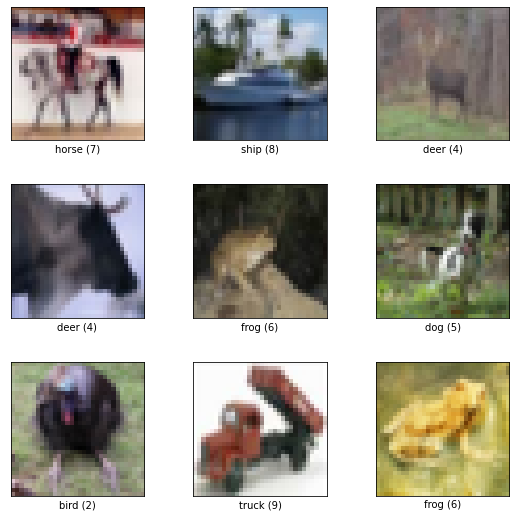

In [143]:
fig = tfds.show_examples(filtered_ds_train, ds_info)

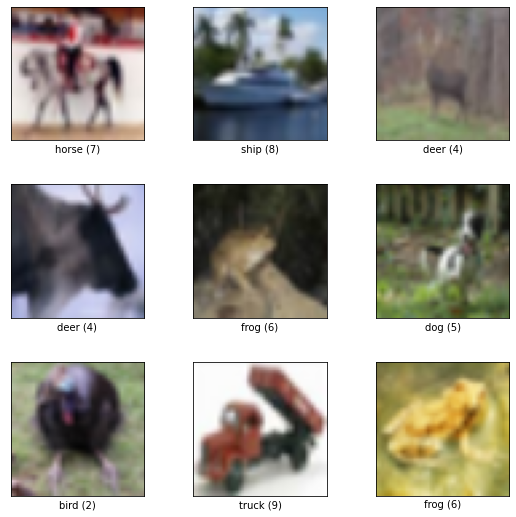

In [144]:
#ds_example = ds_train.take(10)
fig = tfds.show_examples(resized_ds_train, ds_info)

Prepare the model
For Batchnorm, refer https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization

Here they say that During training, the layer normalizes its output using the mean and standard deviation of the **current batch** of inputs.

In order to make BatchNorm great, should we be using a larger batch as input?

However, during Inference mode, the mean ans tsd deviation does not correspond to the current batch. Rather it is a moving mean and std dev of all the bacthes seen in training phase. (Thus, the parameters in inference phase for batch norm do not change)

In [145]:
input_shape = (IMG_SIZE,IMG_SIZE,NUM_CHANNELS)

In [146]:
reg = tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)

model = models.Sequential()
#model.add(resize_and_rescale)

kernel_size = (5,5)
model.add(layers.Conv2D(64, kernel_size, padding="same", input_shape = input_shape, kernel_regularizer = reg))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
model.add(layers.BatchNormalization())
pool_size = (2,2)
model.add(layers.MaxPool2D(pool_size))

kernel_size = (3,3)
model.add(layers.Conv2D(192, kernel_size, padding="same", kernel_regularizer = reg))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
model.add(layers.BatchNormalization())
pool_size = (2,2)
model.add(layers.MaxPool2D(pool_size))

if DataSet != 'cifar10':
    kernel_size = (3,3)
    model.add(layers.Conv2D(64, kernel_size, padding="same", kernel_regularizer = reg))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
    model.add(layers.BatchNormalization())
    pool_size = (2,2)
    model.add(layers.MaxPool2D(pool_size))
    
    kernel_size = (3,3)
    model.add(layers.Conv2D(128, kernel_size, padding="same", kernel_regularizer = reg))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
    model.add(layers.BatchNormalization())
    pool_size = (2,2)
    model.add(layers.MaxPool2D(pool_size))

model.add(layers.Flatten())
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

In [147]:
Learning_Rate = 1e-5                                            #https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
opt = tf.keras.optimizers.Adam(learning_rate=Learning_Rate)     #OR tf.keras.optimizers.SGD(learning_rate=Learning_Rate, momentum=0.0)
#model.compile( optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'] )
model.compile( optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'] )


model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 50, 50, 64)        4864      
                                                                 
 batch_normalization_24 (Bat  (None, 50, 50, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 25, 25, 192)       110784    
                                                                 
 batch_normalization_25 (Bat  (None, 25, 25, 192)      768       
 chNormalization)                                                
                                                     

Reference: https://github.com/tensorflow/datasets/issues/720

In [148]:
#resized_ds_train = resized_ds_train.cache()

#resized_ds_train = resized_ds_train.shuffle(buffer_size)
resized_ds_train = resized_ds_train.batch(BATCH_SIZE)
resized_ds_test = resized_ds_test.batch(BATCH_SIZE)
#resized_ds_train = resized_ds_train.prefetch(tf.data.AUTOTUNE)

Evaluation

In [149]:
h = model.fit( resized_ds_train, epochs=10)

Epoch 1/10
899/899 [==============================] - 67s 74ms/step - loss: 29.3721 - accuracy: 0.3344
Epoch 2/10
899/899 [==============================] - 67s 74ms/step - loss: 23.2889 - accuracy: 0.3954
Epoch 3/10
899/899 [==============================] - 67s 74ms/step - loss: 18.4552 - accuracy: 0.4206
Epoch 4/10
899/899 [==============================] - 67s 75ms/step - loss: 14.7410 - accuracy: 0.4406
Epoch 5/10
899/899 [==============================] - 66s 73ms/step - loss: 12.0054 - accuracy: 0.4550
Epoch 6/10
899/899 [==============================] - 67s 75ms/step - loss: 10.0324 - accuracy: 0.4686
Epoch 7/10
899/899 [==============================] - 66s 74ms/step - loss: 8.6000 - accuracy: 0.4781
Epoch 8/10
899/899 [==============================] - 66s 74ms/step - loss: 7.5364 - accuracy: 0.4866
Epoch 9/10
899/899 [==============================] - 66s 74ms/step - loss: 6.7245 - accuracy: 0.4927
Epoch 10/10
899/899 [==============================] - 66s 73ms/step - loss:

In [150]:
loss,acc = model.evaluate(resized_ds_test)

79/79 [==============================] - 2s 19ms/step - loss: 5.8018 - accuracy: 0.5177


Define evaluator

In [151]:
def ret_as_numpy():
    test = tfds.load(DataSet, split='test', as_supervised=True)
    test = prepare(test)
    test = tfds.as_numpy(test)
    return test

In [152]:
def evaluate_float_model(model, test):
    test_labels = []
    
    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for i, test_example in enumerate(test):
        if i % 1000 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
        test_labels.append(test_example[-1])
        test_image = test_example[0]
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        #display(test_image.shape)
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        #test_image = np.expand_dims(test_image, axis=3).astype(np.float32)
        #display(test_image.shape)
        
        # Run inference.
        output = model(test_image, training=False)
        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = output.numpy()
        #display(output[0])
        digit = np.argmax(output[0])
        prediction_digits.append(digit)
        
    print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy.
    #display(prediction_digits)
    #display(test_labels)
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

In [153]:
test_as_np = ret_as_numpy()

In [154]:
test_accuracy = evaluate_float_model(model, test_as_np)

print('Float test_accuracy:', test_accuracy)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.


Float test_accuracy: 0.5177


Model trained. Now we will create float as well as quantized model

In [155]:
! pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot
quantize_model = tfmot.quantization.keras.quantize_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 13.7 MB/s eta 0:00:00


In [156]:

q_aware_model = quantize_model(model)
#q_aware_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
q_aware_model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
q_aware_model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 50, 50, 3)        3         
 er)                                                             
                                                                 
 quant_conv2d_24 (QuantizeWr  (None, 50, 50, 64)       4993      
 apperV2)                                                        
                                                                 
 quant_batch_normalization_2  (None, 50, 50, 64)       259       
 4 (QuantizeWrapperV2)                                           
                                                                 
 quant_max_pooling2d_24 (Qua  (None, 25, 25, 64)       1         
 ntizeWrapperV2)                                                 
                                                                 
 quant_conv2d_25 (QuantizeWr  (None, 25, 25, 192)    

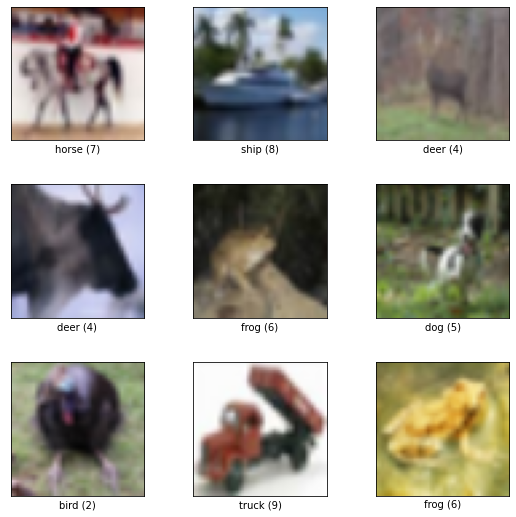

In [157]:
quantize_train, quant_train_info = tfds.load(DataSet, split='train + test[:75%]', with_info=True, as_supervised=True)
filtered_quantize_train = quantize_train.filter(lambda x, y: filter_fn(y, class_list))
#resized_quantize_train = prepare(filtered_quantize_train, resize_only=True)
resized_quantize_train = prepare(filtered_quantize_train)

fig = tfds.show_examples(resized_quantize_train, ds_info)


In [158]:
resized_quantize_train = resized_quantize_train.batch(BATCH_SIZE)
q_aware_model.fit(resized_quantize_train, epochs=5)

Epoch 1/5
450/450 [==============================] - 26s 56ms/step - loss: 5.2528 - accuracy: 0.5912
Epoch 2/5
450/450 [==============================] - 24s 52ms/step - loss: 4.7993 - accuracy: 0.6243
Epoch 3/5
450/450 [==============================] - 21s 48ms/step - loss: 4.5320 - accuracy: 0.6343
Epoch 4/5
450/450 [==============================] - 22s 48ms/step - loss: 4.3207 - accuracy: 0.6417
Epoch 5/5
450/450 [==============================] - 22s 49ms/step - loss: 4.1412 - accuracy: 0.6470


In [159]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [160]:
def evaluate_model(interpreter, test):
    test_labels = []


    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for i, test_example in enumerate(test):
        if i % 1000 == 0:
            print('Evaluated on {n} results so far.'.format(n=i))
        test_labels.append(test_example[-1])
        test_image = test_example[0]
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        #display(test_image.shape)
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        #test_image = np.expand_dims(test_image, axis=3).astype(np.float32)
        #display(test_image.shape)
        interpreter.set_tensor(input_index, test_image)
        
        # Run inference.
        interpreter.invoke()
        
        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
        
    print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy.
    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

Evaluate

In [161]:
#Models obtained from TfLiteConverter can be run in Python with Interpreter.
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
#Since TensorFlow Lite pre-plans tensor allocations to optimize inference, the user needs to call allocate_tensors() before any inference.
interpreter.allocate_tensors()


test_accuracy = evaluate_model(interpreter, test_as_np)

print('Quant TFLite test_accuracy:', test_accuracy)
#print('Quant TF test accuracy:', q_aware_model_accuracy)

Evaluated on 0 results so far.
Evaluated on 1000 results so far.
Evaluated on 2000 results so far.
Evaluated on 3000 results so far.
Evaluated on 4000 results so far.
Evaluated on 5000 results so far.
Evaluated on 6000 results so far.
Evaluated on 7000 results so far.
Evaluated on 8000 results so far.
Evaluated on 9000 results so far.


Quant TFLite test_accuracy: 0.6335


Save the Float model

In [ ]:
MODEL_DIR = "CadenceNet_Float"
model.save(MODEL_DIR, save_format="tf")

In [ ]:
#convert to onnx
!pip install -U tf2onnx
!python -m tf2onnx.convert --saved-model /content/CadenceNet_Float/ --output /content/CadenceNet_Float_sparseCrossEntropy.onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-01-27 10:59:40,910 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-01-27 10:59:41,425 - INFO - Signatures found in model: [serving_default].
2023-01-27 10:59:41,425 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-01-27 10:59:41,426 - INFO - Output names: ['dense_1']
2023-01-27 10:59:41,585 - INFO - Using tensorflow=2.9.2, onnx=1.13.0, tf2onnx=1.13.0/2c1db5
2023-01-27 10:59:41,586 - INFO - Using opset <onnx, 13>
2023-01-27 10:59:41,709 - INFO - Computed 0 values for constant folding
2023-01-27 10:59:41,804 - INFO - Optimizing ONNX model
2023-01-27 10:59:41,873 - INFO - After optimizat

Save QAT model

In [ ]:
quant_file = "/content/quantized_model_sparseCrossEntropy_Rescaled.tflite"
open(quant_file, "wb").write(quantized_tflite_model)

503288

In [ ]:
print("Float model in Mb:", os.path.getsize("/content/CadenceNet_Float_sparseCrossEntropy.onnx") / float(2**20))
print("Quantized model in Mb:", os.path.getsize(quant_file) / float(2**20))